In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\student\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **1. Pre-Processing**
1. Tokenization
2. Stemming/lemmatization
3. Bow/TF-IDF 

In [3]:
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
      
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [4]:
def tokenize_lemmatizor(frame):
    words = []
    lemma_words = []
    lemma_sentences = []
    lemmatizer = WordNetLemmatizer()

    for i in range(len(frame)):
        words = nltk.word_tokenize(frame.iloc[i])
        lemma_words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
        lemma_sentences.append(" ".join(lemma_words))

    return lemma_sentences

In [5]:
def re_lemmatizor(frame):
    lemmatizer = WordNetLemmatizer()
    review = []
    corpus = []

    for i in range(len(frame)):
        review = re.sub('[^a-zA-Z]', ' ', frame.iloc[i])
        review = review.lower()
        review = review.split()
        # these lines represent - words = nltk.word_tokenize(frame.cmd[i])

        review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
        # lemma_words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))])
        
        corpus.append(" ".join(review))
        # lemma_sentences.append(" ".join(lemma_words))

    return corpus

### 3.1. BOW

In [6]:
def custom_tokens_bow(corpus_tokens):
    tokens = re_lemmatizor(corpus_tokens)
    vocab = []
    for sentence in tokens:
        vocab.extend(sentence.split())
    
    features = list(set(vocab))
    bow = []
    for sentence in tokens:
        sent_dict = {}
        for word in sentence.split():
            sent_dict[word] = sent_dict.get(word, 0) + 1
        bow.append([sent_dict[feature] if feature in sent_dict.keys() else 0 for feature in features ])
    # print("Total Vocab Count:", len(features))
    features = np.array(features)
    return np.array(bow), features

In [7]:
from sklearn.feature_extraction.text import CountVectorizer # bow
def tokens_to_bow(corpus_tokens, tokenizer=1):
    cv = CountVectorizer(max_features=5000)
    tokens = []
    if tokenizer == 1:
        tokens = tokenize_lemmatizor(corpus_tokens)
        X_bow = cv.fit_transform(tokens).toarray()
    else:
        tokens = re_lemmatizor(corpus_tokens)
        X_bow = cv.fit_transform(tokens).toarray()
    features = cv.get_feature_names_out()
    return X_bow, features

### 3.2. TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf
def tokens_to_tfidf(corpus_tokens, tokenizer=1):
    tfidf = TfidfVectorizer()
    tokens = []
    if tokenizer:
        tokens = tokenize_lemmatizor(corpus_tokens)
        X_tfidf = tfidf.fit_transform(tokens).toarray()
    else:
        tokens = re_lemmatizor(corpus_tokens)
        X_tfidf = tfidf.fit_transform(tokens).toarray()
    return X_tfidf, tokens

## **Implementation**

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from random import randint, choices, randrange, random, sample, shuffle

In [10]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

In [11]:
from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [12]:
classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'DecisionTree', 'KNeighbors',
               'MultinomialNB']
               

In [13]:
models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          MultinomialNB()]

In [14]:
def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    exec_time = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i

        st = time.time()
        model.fit(X_train,Y_train)
        et = time.time()

        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        exec_time.append(et-st)
        j = j+1     
    Score["Accuracy"] = acc
    Score['Exec_Time_secs'] = exec_time
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

In [15]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [16]:
def initial_population_term_selection_tf(tf_terms, tf_threshold):
    selected_indexes = []
    selected_terms = []
    tf_dict = dict(tf_terms)
    for word, tf in tf_dict.items():
        if tf >= tf_threshold:
            selected_terms.append(word)
            selected_indexes.append(all_terms.index(word))
    return selected_indexes, selected_terms

len(initial_population_term_selection_tf(tf_terms, 0.001)[1])
1566
len(initial_population_term_selection_tf(tf_terms, 0.002)[1])
655
len(initial_population_term_selection_tf(tf_terms, 0.003)[1])
427

In [17]:
def initial_population_term_selection_idf(idf, idf_threshold):
    selected_indexes = []
    selected_terms = []
    idf_dict = dict(idf)
    for word, idf in idf_dict.items():
        if idf <= idf_threshold:
            selected_terms.append(word)
            selected_indexes.append(all_terms.index(word))
    return selected_indexes, selected_terms

len(initial_population_term_selection_idf(idf, 2.6)[1])
418
len(initial_population_term_selection_idf(idf, 2.7)[1])
651
len(initial_population_term_selection_idf(idf, 2.8)[1])
651
len(initial_population_term_selection_idf(idf, 2.9)[1])
651
len(initial_population_term_selection_idf(idf, 3)[1])
1553

In [18]:
def generate_chromo(selected_indexes, features_count, chromo_size):
    features = sample(selected_indexes, k=features_count)
    features.sort()
    chromo = [1 if i in features else 0 for i in range(chromo_size)]
    return np.array(chromo)

In [20]:
def generate_population(size, features_count, chromo_size, selected_indexes):
    return [generate_chromo(selected_indexes, features_count, chromo_size) for _ in range(size)]

In [41]:
def single_point_crossover(pop_after_sel, probability):
    shuffle(list(pop_after_sel))
    pop_nextgen = pop_after_sel
    length = len(pop_nextgen)
    chrom_l = len(pop_nextgen[0])

    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_sel))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1], reverse=True))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2
    pop_1 = pop_sorted_tfidf[:mid]
    pop_2 = pop_sorted_tfidf[mid:]
    
    i=0
    j=0
    m = len(pop_1)
    n = len(pop_2)
    # print(m, n)
    
    while i<m and j<n:
        parent_1, parent_2 = pop_after_sel[int(pop_1[i])], pop_after_sel[int(pop_2[j])]
        if random() <= probability:
            k = randint(1, chrom_l - 1)  # crossover_point
            new_child_1 = np.concatenate([parent_1[:k], parent_2[k:]])
            new_child_2 = np.concatenate([parent_2[:k], parent_1[k:]])
            pop_nextgen.append(new_child_1)
            pop_nextgen.append(new_child_2)
        else:
            pop_nextgen.append(parent_1)
            pop_nextgen.append(parent_2)
        i+=1
        j+=1
        
    while i<m:
        parent_1 = pop_after_sel[int(pop_1[i])]
        pop_nextgen.append(parent_1)
        i+=1
    
    while j<n:
        parent_2 = pop_after_sel[int(pop_2[j])]
        pop_nextgen.append(parent_2)
        j+=1
    
    return pop_nextgen

In [45]:
def single_point_crossover1(pop_after_sel, n_parents):
    shuffle(list(pop_after_sel))
    pop_nextgen = pop_after_sel
    length = len(pop_nextgen)
    chromo_l = len(pop_nextgen[0])

    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_sel))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1]))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2
    pop_1 = pop_sorted_tfidf[:mid]
    pop_2 = pop_sorted_tfidf[mid:]

    for i in range(0, mid):
        parent_1, parent_2 = pop_after_sel[int(pop_1[i])], pop_after_sel[int(pop_2[i])]
        p1_features = list(np.where(np.array(parent_1) != 0)[0])
        p2_features = list(np.where(np.array(parent_2) != 0)[0])

        k = randint(0,len(p1_features))  # crossover_point
        c1_features = p1_features[:k] + p2_features[k:]
        c2_features = p2_features[:k] + p1_features[k:]

        c1_dup = list(set([i for i in c1_features if c1_features.count(i) > 1]))
        c2_dup = list(set([i for i in c2_features if c2_features.count(i) > 1]))
            # print("duplicates:", c1_dup, c2_dup)
            
        if len(c1_dup) > 0:
            sample_pop1 = [i for i in p1_features if i not in c1_features]
            k1 = sample(sample_pop1, k=len(c1_dup))
            for i in c1_dup:
                c1_features.remove(i)
            c1_features.extend(k1)
        elif len(c2_dup) > 0:
            sample_pop2 = [i for i in p2_features if i not in c2_features]
            k2 = sample(sample_pop2, k=len(c2_dup))
            for i in c2_dup:
                c2_features.remove(i)
            c2_features.extend(k2)

        new_child_1 = np.array([1 if i in c1_features else 0 for i in range(chromo_l)])
        new_child_2 = np.array([1 if i in c2_features else 0 for i in range(chromo_l)])
        pop_nextgen.append(new_child_1)
        pop_nextgen.append(new_child_2)
        
    _, pop_nextgen = fitness_score(pop_nextgen)
    return pop_nextgen[:n_parents]

In [43]:
def bit_flip_mutation(pop_after_cross, probability, mutation_rate1, mutation_rate2, n_feat):   
    n_feat = pop_after_cross[0].shape[0]
    # print(n_feat)
    
    range1 = int(mutation_rate1*n_feat)
    range2 = int(mutation_rate2*n_feat)
    pop_next_gen = []
    
    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_cross))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1], reverse=True))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2+1
    for n in pop_sorted_tfidf:
        if mid >= 0:
            mutation_range = range1
        else:
            mutation_range = range2
            
        chromo = pop_after_cross[int(n)]
        rand_posi = []
        if random() <= probability:
            for i in range(0,mutation_range):
                pos = randint(0,n_feat-1)
                rand_posi.append(pos)
            for j in rand_posi:
                chromo[j] = abs(chromo[j] - 1)
        pop_next_gen.append(chromo)
        mid -= 1
    
    return pop_next_gen

In [44]:
def bit_flip_mutation1(pop_after_cross, mutation_rate1, mutation_rate2, features_count, n_parents):   
    range1 = int(mutation_rate1*features_count)
    range2 = int(mutation_rate2*features_count)
    pop_next_gen = list(pop_after_cross)
    # print(range1, range2)
    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_cross))
    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1]))[:, 0]
    
    mid = len(pop_sorted_tfidf)//2+1
    for n in pop_sorted_tfidf:
        if mid >= 0:
            mutation_range = range1
        else:
            mutation_range = range2
            
        chromo = pop_after_cross[int(n)]
        features = list(np.where(chromo != 0)[0])
        non_features = list(np.setdiff1d(np.array(range(chromo.shape[0])), features))

        rand_posi = []

        features_pos = sample(features, k=mutation_range)
        non_features_pos = sample(non_features, k=mutation_range)
        rand_posi.extend(features_pos)
        rand_posi.extend(non_features_pos)
        for j in rand_posi:
            chromo[j] = abs(chromo[j] - 1)
            
        pop_next_gen.append(chromo)
        mid -= 1

    _, pop_next_gen = fitness_score(pop_next_gen)
    return pop_next_gen[:n_parents]

In [1]:
def population_selection(pop_after_fit, tfidf_threshold):
    tf_idf_sent_score = term_frequency_inverse_document_frequency(pop_after_fit)
    sent_indexes = [i for i, j in tf_idf_sent_score if j >= tfidf_threshold]
    sent_indexes.sort()
    population_nextgen = []
    for i in sent_indexes:
        population_nextgen.append(pop_after_fit[i])
    # print("from selec: ", tf_idf_sent_score)
    return population_nextgen

In [50]:
# def population_selection(pop_after_fit, n_parents):
#    tf_idf_sent_score = dict(term_frequency_inverse_document_frequency(pop_after_fit))
#    # n_parents = int(len(pop_after_fit)*(n_parents/100))
#    pop_sorted_tfidf = np.array(sorted(tf_idf_sent_score.items(), key=lambda x: x[1]))[:n_parents,0]
#    print(pop_sorted_tfidf)
#    population_nextgen = []
#    for i in pop_sorted_tfidf:
#        population_nextgen.append(pop_after_fit[int(i)])
#    return population_nextgen

In [27]:
# pop = np.array([1,2,3,4,5,6,7])
# inds = [3, 0, 2, 1, 6, 4, 5]
# pop[inds]

In [51]:
def fitness_score(population):
    scores = []
    for chromosome in population:
        indexes = np.where(chromosome!=0)[0]
        logmodel.fit(X_train[:,indexes],Y_train)    
        predictions = logmodel.predict(X_test[:,indexes])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

In [47]:
def term_frequency(population):
    tf_sent = []
    tf_dict = {}
    total_no_terms = len(population)
    for chromosome in population:
        chromo_tf = []
        indexes = np.where(chromosome!=0)
        for i in indexes[0]:
            chromo_tf.append(chromosome[i]/total_no_terms)
            tf_dict[all_terms[i]] = tf_dict.get(all_terms[i], 0) + (chromosome[i]/total_no_terms)
        tf_sent.append(chromo_tf)
    
    tf_terms = sorted(tf_dict.items(), key=lambda x: x[1], reverse=True)
    return tf_sent, tf_terms

In [48]:
def inverse_document_frequency(population):
    idf = {}
    terms = np.array(list(all_terms))
    no_documents = len(population)
    for i in range(len(all_terms)):
        k = 0
        for chromosome in population:
            indexes = np.where(chromosome!=0)
            if terms[i] in terms[indexes]:
                k += 1
        idf[terms[i]] = np.log10(no_documents/k)
    idf = sorted(idf.items(), key=lambda x: x[1], reverse=True)
    return idf

In [49]:
def term_frequency_inverse_document_frequency(population):
    tf_sent, tf_terms = term_frequency(population)
    tf_idf = {}
    idf_dict = dict(idf)
    for i in range(len(population)):
        tf_idf_sent = []
        indexes = np.where(population[i] != 0)[0]
        for j in range(len(indexes)):
            idf_term = idf_dict[all_terms[indexes[j]]]
            tf = tf_sent[i][j]
            tf_idf_sent.append(tf*idf_term)
        tf_idf[i] = sum(tf_idf_sent)/len(indexes)
    tf_idf = sorted(tf_idf.items(), key=lambda x: x[1], reverse=True)
    return tf_idf

In [32]:
def evolution(size, features_count, chromo_size,
            n_parents,
            crossover_pb, mutation_pb,
            mutation_rate1,
            mutation_rate2,
            n_gen,
            idf, idf_threshold,
            tf, tf_threshold,
            tfidf_threshold):
    best_chromo= []
    best_score= []
    
    
    selected_indexes, selected_terms = initial_population_term_selection_idf(idf, idf_threshold)
    # selected_indexes, selected_terms = initial_population_term_selection_tf(tf, tf_threshold)

    population_nextgen=generate_population(size, features_count, chromo_size, selected_indexes)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        print('Best score in generation',i+1,':',scores[0], "feat_count:", np.where(pop_after_fit[0] != 0)[0].shape)

        pop_after_sel = population_selection(pop_after_fit, idf_threshold)
        # sc_sel, pop_sel = fitness_score(pop_after_sel)
        # print('Best score in generation',i+1,':',sc_sel[0], "feat_count:", np.where(pop_sel[0] != 0)[0].shape)

        pop_after_cross = single_point_crossover1(pop_after_sel, n_parents)
        # sc_co, pop_co = fitness_score(pop_after_cross)
        # print('Best score in generation',i+1,':',sc_co[0], "feat_count:", np.where(pop_co[0] != 0)[0].shape)

        population_nextgen = bit_flip_mutation1(pop_after_cross, mutation_rate1, mutation_rate2, features_count, n_parents)
        # sc_mu, pop_mu = fitness_score(population_nextgen)
        # print('Best score in generation',i+1,':',sc_mu[0], "feat_count:", np.where(pop_mu[0] != 0)[0].shape)

        # # new next gen population will have the evolved population + the initial population after fitness_score
        # population_nextgen += pop_after_sel
        # _, population_new_nextgen = fitness_score(population_nextgen)
        # print('Best score in generation',i+1,':',_[0], "feat_count:", np.where(population_new_nextgen[0] != 0)[0].shape)
        # population_nextgen = population_selection(population_new_nextgen, n_parents)
        print(len(population_nextgen))
        
    return best_chromo,best_score

# **Accuracy Comparison**

## **For Amazon dataset**

### Data Preprocessing

In [2]:
amazon = pd.read_csv("../dataset/amazon.csv", encoding="latin1")
frame = amazon.copy()
frame

NameError: name 'pd' is not defined

*Difference between a stemmed and lemmatized words*

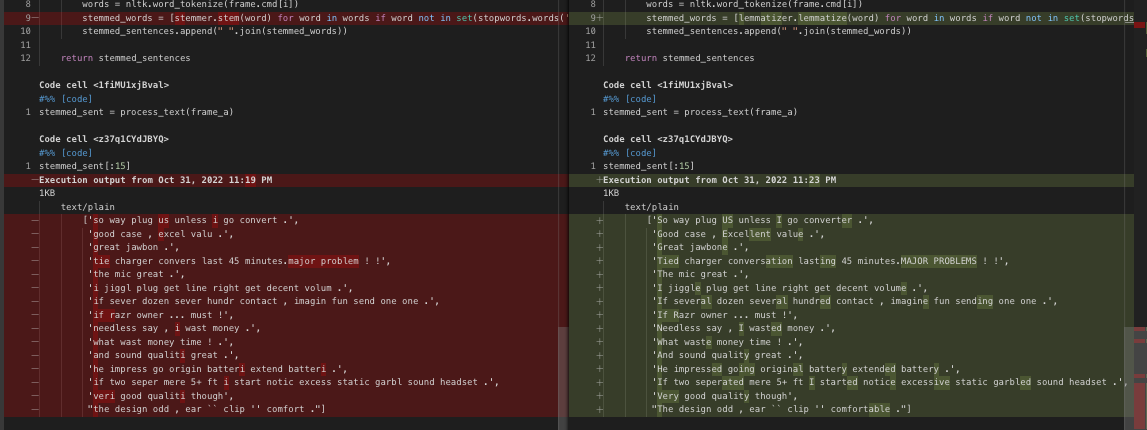

In [33]:
X_bow, features = tokens_to_bow(frame.cmd, 0)
y_score = frame.score
all_terms = list(features)

In [34]:
X_train, X_test, Y_train, Y_test = split(X_bow, y_score)

In [35]:
idf = inverse_document_frequency(X_bow)
tf_sent, tf_terms = term_frequency(X_bow)

### Compare models without GA

In [36]:
all_models_score_table = acc_score(X_bow, y_score)
all_models_score_table

,Classifier,Accuracy,Exec_Time_secs
0,RandomForest,0.800,1.199782
1,MultinomialNB,0.796,0.008976
2,LinearSVM,0.780,0.727575
3,Logistic,0.776,0.056848
4,DecisionTree,0.772,0.167551
5,RadialSVM,0.756,0.576602
6,KNeighbors,0.648,0.000998


### Choosing the best classifier and starting evolution

In [37]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)

### Trying different parameters

In [92]:
st = time.time()
chromo_set_1, score_set_1 = evolution(
    size=100, 
    features_count=100,
    chromo_size=X_bow.shape[1],
    n_parents=80,
    crossover_pb=0.8,
    mutation_pb=0.05,
    mutation_rate1=0.05,
    mutation_rate2=0.1,
    n_gen=3,
    idf = idf,
    idf_threshold=2.7,
    tf = tf_sent,
    tf_threshold = 0.002,
    tfidf_threshold = 0.0339
)
et = time.time()

Best score in generation 1 : 0.664 feat_count: (100,)
TFIDF+Accuracy [0.6835778278579001, 0.6835778278579001, 0.6795711202694866, 0.6795711202694866, 0.6715697149615478, 0.6715697149615478, 0.6715622793561254, 0.6715622793561254, 0.6715579530684063, 0.6715579530684063, 0.6675550855728316, 0.6675550855728316, 0.667554010680114, 0.667554010680114, 0.667554010680114, 0.667554010680114, 0.667549496596468, 0.667549496596468, 0.6595439937446226, 0.6595439937446226, 0.6595437417364406, 0.6595437417364406, 0.6595432392328181, 0.6595432392328181, 0.6595421608563139, 0.6595421608563139, 0.6595421608563139, 0.6595421608563139, 0.6515363975449866, 0.6515363975449866, 0.6435355833669589, 0.6435355833669589, 0.6435355833669589, 0.6435355833669589, 0.643534519382201, 0.643534519382201, 0.6435343087117126, 0.6435343087117126, 0.6395343087117126, 0.6395343087117126, 0.6355328326504514, 0.6355328326504514, 0.6355307850898219, 0.6355307850898219, 0.6355307850898219, 0.6355307850898219, 0.6355279414081596

KeyboardInterrupt: 

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

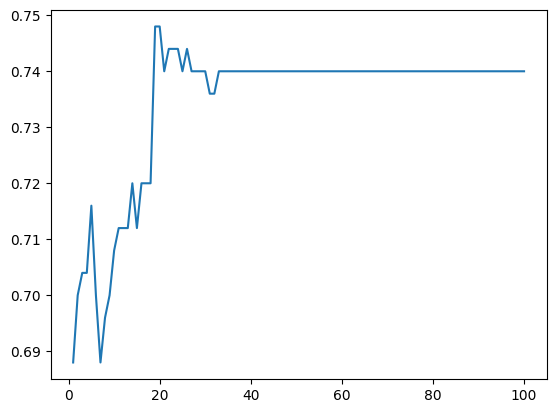

In [77]:
sns.lineplot(x=list(range(1, 101)), y=score_set_1)

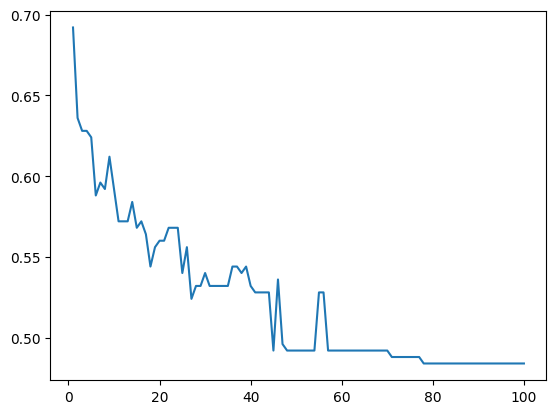

the tfidf value sorting were done in reverse order, so the graph is reversed

In [78]:
import pickle
with open('single_run_az_kbga1.pkl', 'wb') as wf:
    pickle.dump([chromo_set_1, score_set_1, et-st], wf)

In [87]:
# si = initial_population_term_selection_idf(idf, 2.7)[0]
# pop = generate_population(100, 100, 1553, si)

In [88]:
# try to corr map for accuracy and tfidf

In [ ]:
def run_n_evolution(n):
    result_n_runs = []
    for i in range(n):
        chromo_set_2, score_set_2 = evolution(
        size=100, 
        features_count=100,
        chromo_size=X_bow.shape[1],
        n_parents=80,
        crossover_pb=0.8,
        mutation_pb=0.05,
        mutation_rate1=0.1,
        mutation_rate2=0.3,
        n_gen=40,
        idf = idf,
        idf_threshold=2.6,
        tf = tf_sent,
        tf_threshold = 0.002,
        tfidf_threshold = 0.0339,
    )
        result_n_runs.append((chromo_set_2, score_set_2))
    return result_n_runs

In [ ]:
# plot(score_set_2, 0.5, 1.0, c = "green")

In [ ]:
results = run_n_evolution(30)

In [ ]:
import pickle
with open('n_run_imdb_kbga.pkl', 'wb') as wf:
    pickle.dump(results, wf)